In [25]:
import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import os; 
from sys import platform; import numpy as np; from scipy.stats import spearmanr;

from random import seed

%matplotlib inline

In [3]:
home = os.path.expanduser('/lab_data/coaxlab/Projects'); data_dir = os.path.join(home, 'dynamic_decision_policy_reconfiguration/aggregated_data/loki_0.5')

ls_df = pd.read_csv(os.path.join(data_dir, 'av_manifold_df.csv'))

In [6]:
ls_df.subj_id.unique()

array([786, 787, 788, 789])

In [5]:
print(ls_df.head()); ls_df.columns

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1       cpp      b_t0      b_t1  \
0           0             0               0  0.076938  1.038488  3.199304   
1           1             1               1  0.319389  1.073995  2.636439   
2           2             2               2  0.300755  1.210057  1.084931   
3           3             3               3  0.365146  1.297258  2.998052   
4           4             4               4  0.074485  1.371289  0.931292   

         MC       H  signed_B_diff   ideal_B  ...  theta_deg   a_est_z  \
0  0.383517  0.0975       0.000000 -2.160816  ...        NaN       NaN   
1  0.604624  0.0975       2.160816 -1.562444  ...        NaN  0.372983   
2  0.467104  0.0975       1.562444  0.125126  ...  92.897581 -0.833442   
3  0.489297  0.0975      -0.125126 -1.700794  ...  89.920968 -0.740719   
4  0.456994  0.0975       1.700794  0.439997  ... -90.252403 -1.061126   

    v_est_z  theta_deg_360  theta_deg_abs_180       r_z  theta_radians_z  \
0       NaN     

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1.1', u'cpp', u'b_t0',
       u'b_t1', u'MC', u'H', u'signed_B_diff', u'ideal_B', u'lambda_val',
       u'p_optimal', u'trial', u'subj_id', u'reward_code', u'condition',
       u'run', u'LR_choice', u'value_accuracy', u'value_LR_solution',
       u'reward', u'cumulative_reward', u'rt', u'total_trial_time', u'iti',
       u'cp_list', u'obs_cp_list', u'high_val_cue', u'high_p_cue',
       u'p_accuracy', u'p_LR_solution', u'p_id_solution', u'id_choice',
       u'stim_duration', u'stim_onset', u'stim_offset', u'abs_response_time',
       u'epoch_length', u'epoch_trial', u'epoch_number',
       u'shifted_epoch_trial', u'ideal_B_shifted', u'cpp_shifted', u'a_est',
       u'v_est', u'epoch_window_number', u'r', u'theta_radians', u'theta_deg',
       u'a_est_z', u'v_est_z', u'theta_deg_360', u'theta_deg_abs_180', u'r_z',
       u'theta_radians_z', u'theta_deg_z', u'theta_deg_360_z',
       u'theta_deg_abs_180_z'],
      dtype='object')

In [7]:
ls_df_pared = ls_df.loc[(ls_df.shifted_epoch_trial >= -1) & (ls_df.shifted_epoch_trial <= 3)].reset_index(drop=True)

## Quantifying the correlation between $\Delta B$ and $\Omega$

In [8]:
ls_df_pared.groupby(['subj_id'])[['ideal_B', 'cpp']].corr(method='spearman') # subject-wise correlation 

ideal_B       cpp
subj_id                            
786     ideal_B  1.000000 -0.274242
        cpp     -0.274242  1.000000
787     ideal_B  1.000000 -0.247258
        cpp     -0.247258  1.000000
788     ideal_B  1.000000 -0.194763
        cpp     -0.194763  1.000000
789     ideal_B  1.000000 -0.220673
        cpp     -0.220673  1.000000

In [9]:
ls_df_pared[['ideal_B', 'cpp']].corr(method='spearman') # pooled correlation

,ideal_B,cpp
ideal_B,1.000000,-0.232458
cpp,-0.232458,1.000000


## An estimate of confidence 

### percentile bootstrap of the correlations (95% CI)

In [10]:
def pairwise_percentile_bootstrap(x, y, n_resamples=1000, func=spearmanr):
    
    idx = np.arange(len(x))
    size = len(idx)
    
    resampled_x, resampled_y = list(), list()
    
    resampled_spearman_r = list() 
    
    for n in range(n_resamples):
        
        resampled_idx = np.random.choice(idx, size=size, replace=True)   # resample indices with replacement
        
        resampled_x_n, resampled_y_n = x[resampled_idx], y[resampled_idx] # get resampled values of x & y 
        
        corr_n, _ = spearmanr(resampled_x_n, resampled_y_n) # correlation of resampled values (ignore p-value)
        
        resampled_x.append(resampled_x_n); resampled_y.append(resampled_y_n) # storing resampled vectors

        resampled_spearman_r.append(corr_n) # storing correlation of resampled values
    
    return resampled_x, resampled_y, resampled_spearman_r

In [32]:
def viz_percentiles(resampled_metrics, ci = 95):
    
    sorted_resampled_metrics = np.sort(resampled_metrics)

    lw = 2; font_scale = 1.5
    
    symmetric_ci = (100 - ci )/ 2 
    symmetric_upper_bound, symmetric_lower_bound = 100 - symmetric_ci, symmetric_ci
    metric_percentiles = np.percentile(a=sorted_resampled_metrics, q=[symmetric_upper_bound, symmetric_lower_bound])
    
    mean_metric = np.mean(metric_percentiles)
    
    sns.set(font_scale=font_scale, style='whitegrid')  

    if sns.__version__ == '0.11.2':
        sns.histplot(sorted_resampled_metrics)
    elif sns.__version__ == '0.9.0':
        sns.distplot(sorted_resampled_metrics)
        
    plt.axvline(metric_percentiles[0], color='gray',linewidth=lw)
    plt.axvline(metric_percentiles[1], color='gray', linewidth=lw)
    plt.axvline(mean_metric, color='gray', linewidth=lw)
    sns.despine()
    
    return metric_percentiles, mean_metric

In [43]:
x,y = ls_df_pared.cpp, ls_df_pared.ideal_B
resampled_x, resampled_y, resampled_spearman_r = pairwise_percentile_bootstrap(x,y)

Text(0.5,0,"Spearman's $\\rho_{B\\Omega}$")

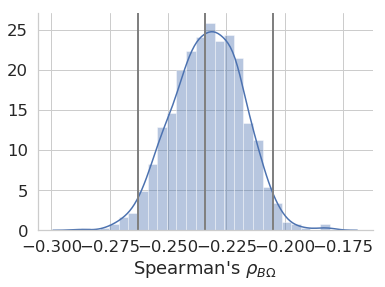

In [44]:
metric_percentiles, mean_metric = viz_percentiles(resampled_spearman_r)
plt.xlabel(r"Spearman's $\rho_{B\Omega}$")

In [45]:
np.round(metric_percentiles,3),  np.round(mean_metric,3)

(array([-0.205, -0.263]), -0.234)

In [46]:
np.round(mean_metric - metric_percentiles[0],3)

-0.029

### Variance Inflation Factor (VIF) & 95% CI

In [27]:
def compute_variance_inflation_factor(correlations):

    vifs = [(1 / (1 - r**2)) for r in correlations]

    return vifs

In [28]:
vifs = compute_variance_inflation_factor(resampled_spearman_r)

Text(0.5,0,'Variance Inflation Factor (VIF)')

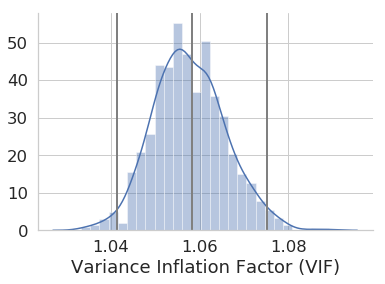

In [35]:
metric_percentiles, mean_metric = viz_percentiles(vifs)
plt.xlabel("Variance Inflation Factor (VIF)")

In [41]:
np.round(metric_percentiles,3),  np.round(mean_metric,3)

(array([-0.202, -0.262]), -0.232)

In [42]:
np.round(mean_metric - metric_percentiles[0],3)

-0.03